# Evaluating Anomaly Detection
- The main goal of the evaluating an anomaly detection is to find out how well does our algorithm performs.
- Since, we mainly focusing on two types of anomaly detection that is supervised anomaly detection and unsupervised anomaly detection, we do have two approaches for evaluation.

## 1. Supervised Anomaly Detection
- As we know, here we have labeled data i.e it's just like a classification problem. So, anomaly detection is a unbalanced classification problem.
- Therefore, can use suitably modified performance metrics for classification.
    - Avoid metrics like accuracy that don’t work well for unbalanced data
- In classification: we care about the value of the score.
- In anomaly detection: we care about the rank of the score
- Anomalies are often detected by assigning each data point a score indicating how likely it is to be an anomaly.
- Typically, we can only examine a certain number of data points, let's call it "n".

### a. Metrics Based on Top n Points:
1. Precision at n: Out of the top n points ranked by their scores, this tells us the fraction that are actually anomalies.
2. Recall at n: Among all the anomalies, this tells us the fraction that are found within the top n points.
3. Average Precision: This is the average of precision values for each position in the top n, considering only positions where an anomaly is found.

Let's see the scoring process of Precision @ n

![Screenshot from 07-02-24 17:58:21](https://github.com/surajkarki66/github-repo-search/assets/50628520/a23290c4-cb22-45d0-ae16-06532c8478ba)


Let's see the scoring process of average precision

![image](https://github.com/surajkarki66/PyTorch/assets/50628520/085ddfca-73b7-4945-85f3-05c4a314cc80)

Let's see the scoring process of recall at n.

![image](https://github.com/surajkarki66/PyTorch/assets/50628520/1ea00be2-24ca-4566-9af5-c929beb4daa7)


4. Adjusted Precision at n:  

**How much better are we doing than a random ordering?**
- If there are A anomalies and N data points, a random ordering of points has and expected Precision at n of  

  Expected(P@n) = (expected # anomalies in top n) / n = n( A / N ) / n = A / N
  
- Adjusted Precision at n is

$$
\text{Adjusted } P@{n} = \frac{A(N-1)}{N^2}
$$


5. Adjusted Average Precision:  
$$
\text{Adjusted AP} = \frac {AP \frac{A}{N}} {\left( 1 - \frac{A}{N} \right)}
$$

- For a good anomaly detector, the adjusted AP > 0
    - For a random ordering AP = 0
    - Orderings worse than average have AP <0


**When to use P@n and adjusted P@n**
- `Not needed`: When comparing different detection methods on the same dataset using the same metric, adjustments for chance are not necessary because the dataset and anomaly proportion remain constant.
- `Must be used` However, if comparing different datasets with varying proportions of anomalies, adjustments for chance are crucial to ensure fair and interpretable comparisons.
- `In all cases`: adjusting for chances helps interpretability

### b. Receiver operator characteristic score( ROC score)
- We can also use the Receiver Operator Characteristic (ROC) curve to evaluate anomaly detectors.
- ROC is very common technique in classification problems specially in binary classification.
- Not sensitive to class imbalance
- Ranks the false negative rate (horizontal axis) against the true positive rate (vertical axis)
- Area under the curve (AUC) is a single number that tells us how well the detector does separating cases:
    - P (randomly chosen anomaly score > randomly chosen normal score) = ROC AUC

## 2. Unsupervised Anomaly Detection
- As we know, here we have unlabeled data.
- In clustering analysis, there are internal measures of cluster “goodness” (e.g. the average distance of a point to cluster centers)
- The types of internal measure used can bias the result toward certain types of clusters
    -  For example, k-means typically scores better than density-based methods if the metric is the average distance of a point to cluster centers
    - Use of internal measures in anomaly detection are generally not used; they introduce too much bias into the method

**Approach**
- Find a classification dataset with similar characteristics / separation or Generate labeled data with similar distributions as the expected anomalies
- Treat one of the classes as the anomaly class. Down-sample if necessary to get a reasonable normal:anomaly ratio.
- Benchmark model on classification dataset
- Investigate anomalies flagged in actual data to see if model generalizes well
- Extra: try mislabeling a few of the “close” anomalies, to see what effect mislabeling has on your dataset
- Never do train-split here.
- Model parameters (e.g. number of neighbors) determined by evaluating metric over a “reasonable” range of parameters
- Model evaluation is given as a box-plot of the outputs on the classification problem after running over the reasonable range of parameters.
- Reasonable ranges generally require subject matter expertise

**Datasets with discrete, unordered values?**
- So far we have focused on datasets with numerical data.
- Many of the techniques presented can be applied to categorical data as well
- The challenges is to construct a meaningful distance function that can be used to analyze the data
    -  For categorical data, distance function is often called a “similarity function”

**Similarity Function**
- Similarity = 1 if categories are the same. Otherwise:
$$
\text{sim}(c_1,c_2) = \frac{1}{1 + \log(n_1) \cdot \log(n_2)}
$$
    - Here nj is the number of elements in category j (with j =1, 2)

**Similarities to distances**
-  If we have d numeric features and c categorical features
$$\text{sim}(x, y) = \sum_{i=1}^{d} x_i y_i + \sum_{i=1}^{c} \text{sim}(x_{c_i}, y_{c_i})$$

- Could use cosine distance (but we lose separation in similarity variable)
$$\text{dist}(x, y) = \frac{cossim(x, x) \cdot \text{sim}(y, y)}{-1 + \text{sim}(x, y)}$$

- Could combine numeric distance and similarity score:
$$\text{squared dist}(x, y) = \sum_{i=1}^{d} (x_i - y_i)^2 + \sum_{i=1}^{c} (1 - \text{sim}(x_{c_i}, y_{c_i}))^2$$

## 3. Other types of anomaly detection
### Three examples
**a. Generative Models**  
- Find the probability distribution to describe the feature space and use this to detect anomalies.
**b.  Information-theoretic models**  
- Anomalies increase amount of information needed to summarize the data
**c. Frequent pattern mining**
-  If an instance of the data contains patterns found frequently, it is unlikely to be an anomaly

# Implementation

## 1. Imports

In [65]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.neighbors as neighbors
import sys


from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from collections import namedtuple
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## 2. Load the dataset
We are going to use sensor logs from the shuttle from the [UCI learning repository](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Shuttle%29). The last column is the (manual) classification of the operational mode of the shuttle.

In [2]:
col_names = [f'attr_{n}' for n in range(9)] + ['class']
df = pd.read_csv('shuttle.tst', delim_whitespace=True, names=col_names)

In [3]:
df.head(10)

,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,class
0,55,0,81,0,-6,11,25,88,64,4
1,56,0,96,0,52,-4,40,44,4,4
2,50,-1,89,-7,50,0,39,40,2,1
3,53,9,79,0,42,-2,25,37,12,4
4,55,2,82,0,54,-6,26,28,2,1
5,41,0,84,3,38,-4,43,45,2,1
6,37,0,100,0,36,-8,63,64,2,1
7,46,0,83,0,46,0,37,36,0,1
8,44,0,79,0,42,-17,35,37,2,1
9,44,-1,78,0,44,0,34,34,0,1


We are going to simulate outlier detection by 
- making class 1 (~80%) the inliners
- dropping the next largest class (class 4)
- combining all other classes as outliers

Before dropping the class column, let's look at the frequency of each class:

In [4]:
df['class'].value_counts()

class
1    11478
4     2155
5      809
3       39
2       13
6        4
7        2
Name: count, dtype: int64

Now to exchange the "class" attribute for the "anomaly" attribute

In [5]:
df = df[ df['class']!=4 ]
df['anomaly'] = (df['class'] != 1).astype(bool)
df.drop('class', axis=1, inplace=True)
df.head()

,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,anomaly
2,50,-1,89,-7,50,0,39,40,2,False
4,55,2,82,0,54,-6,26,28,2,False
5,41,0,84,3,38,-4,43,45,2,False
6,37,0,100,0,36,-8,63,64,2,False
7,46,0,83,0,46,0,37,36,0,False


In [6]:
df['anomaly'].value_counts()

anomaly
False    11478
True       867
Name: count, dtype: int64

We have approximately 7% of the data as anomalous.

Let's evaluate the performance of the IsolationForest on this dataset.

In [7]:
frac_anomalies = df['anomaly'].sum()/df['anomaly'].size

iso_forest = IsolationForest(contamination=frac_anomalies, random_state=42)
y_predict = iso_forest.fit_predict(df.drop('anomaly', axis=1))

/home/surajkarki/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [8]:
y_predict

array([ 1,  1,  1, ...,  1, -1,  1])

In [9]:
msg = f"""
Fraction of anomalies predicted:                 {(y_predict == -1).sum() / y_predict.size}
Fraction of anomalies given to isolation forest: {frac_anomalies}
"""
print(msg)


Fraction of anomalies predicted:                 0.07023086269744835
Fraction of anomalies given to isolation forest: 0.07023086269744835



Note that the fraction of prediction for anomaly (`-1`) matches the `frac_anomalies` parameter exactly

We can access the raw scores from iso_forest.decision_function

In [10]:
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

In [11]:
y_scores

array([ 0.14982987,  0.14135482,  0.19075111, ...,  0.19712148,
       -0.06096018,  0.06979992])

## 3. Precision @ n
Sklearn does not have formula for precision@n built in, so we will have to write our own.
The formula for P@n is
\begin{equation*}
P@n = \frac{\text{# anomalies in first $n$ entries}}{n}
\end{equation*}
Let's write a function for giving us P@n:

In [26]:
def precision_at_n(y_is_anomaly_true, y_scores, n_max = 0):
    """
    y_scores: list of scores (lower means more likely to be an anomaly)
    y_is_anomaly_true: boolean list, y_is_anomaly_true[i] is True 
    iff the ith point is an anomaly
    
    Returns an array of scores for P@n for n in 1, 2, 3, ...., n_max.
    
    If n_max is given as 0, ranks P@n for the entire dataset
    """
    if not n_max:
        n_max = len(y_scores)
    
    is_anomaly_sorted_by_score = [is_anomaly for _, 
                                  is_anomaly in sorted(zip(y_scores, y_is_anomaly_true))]
    return [sum(is_anomaly_sorted_by_score[:n])/n for n in range(1, n_max+1)]

Let's test it out with a dummy example. Here, lower scores are anomaly.

In [27]:
y_scores = np.array([-0.03598, -0.033510, -0.005384, 0.000330])
y_true = np.array([1, 0, 1, 0])

precision_at_n(y_true, y_scores)

[1.0, 0.5, 0.6666666666666666, 0.5]

Let's define custom average precision function.

In [14]:
def custom_average_precision(y_is_anomaly_true, y_scores):
    sorted_scores_and_truth = np.array([(score, is_anomaly) 
                                        for score, is_anomaly in 
                                        sorted(zip(y_scores, y_is_anomaly_true))])
    scores, is_anomaly = sorted_scores_and_truth[:, 0], sorted_scores_and_truth[:, 1]
    p_at_n = np.array(precision_at_n(is_anomaly, y_scores))
    return (is_anomaly * p_at_n).sum() / is_anomaly.sum()

In [15]:
custom_average_precision(y_true, y_scores)

0.8333333333333333

## 4. Precision@n for the shuttle data set

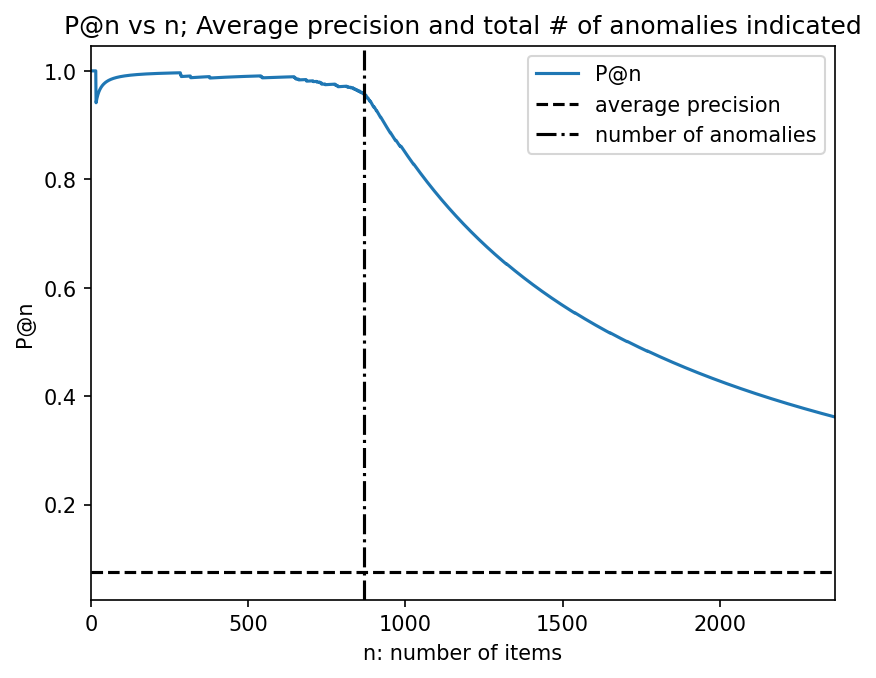

In [16]:
# reset the scores to those produced by our model
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

num_anomalies = sum(df['anomaly'])
average_precision = custom_average_precision(df['anomaly'], y_scores)
plt.figure(dpi=150)

plt.plot(precision_at_n(df['anomaly'], y_scores), label='P@n')
plt.axhline(average_precision, linestyle='--', color='k', 
            label='average precision')
plt.axvline(num_anomalies, linestyle='-.', color='k', label='number of anomalies')
plt.xlim(0, num_anomalies + 1500)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n vs n; Average precision and total # of anomalies indicated');

In [28]:
print(f"The value for average precision is {average_precision:6.4f}")

The value for average precision is 0.0755


We see that P@n depends on the number of items $n$ quite strongly for small n ($n \ll 50$), but then stays relatively constant until $n\sim 869$, the number of anomalies in the data. After that, putting more items from the ranked list just decreases the average precision as the power law $1/n$.

The average precision is only averaged at the location of the anomalies (i.e. early in the dataset), so it is a lot higher than the average of P@n.

What about focusing on that dip at the beginning when $n$ is small?

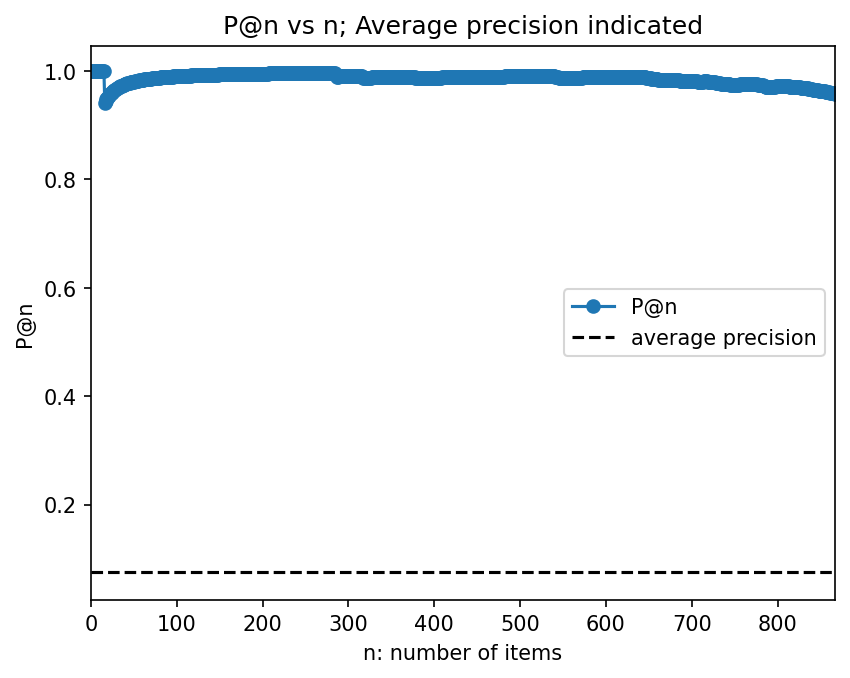

In [35]:
# reset the scores to those produced by our model
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

num_anomalies = sum(df['anomaly'])
average_precision = custom_average_precision(df['anomaly'], y_scores)
plt.figure(dpi=150)

plt.plot(precision_at_n(df['anomaly'], y_scores), label='P@n', marker='o')
plt.axhline(average_precision, linestyle='--', color='k', 
            label='average precision')
plt.xlim(0, num_anomalies)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n vs n; Average precision indicated');

**The adjusted P@n and adjusted average precision**


In [36]:
# reset the scores to those produced by our model
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

num_anomalies = sum(df['anomaly'])
num_points = df['anomaly'].size
frac_anomalies = num_anomalies / num_points

p_at_n = np.array(precision_at_n(df['anomaly'], y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = custom_average_precision(df['anomaly'], y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

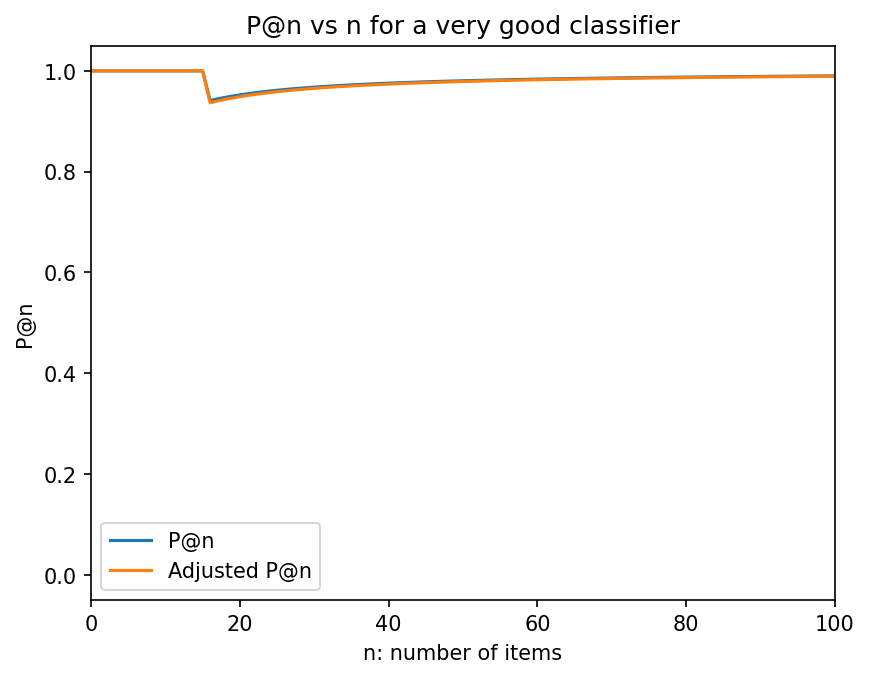

In [37]:
plt.figure(dpi=150)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.xlim(0, 100)
plt.legend()
plt.title('P@n vs n for a very good classifier');

This classifier does such a good job, we are getting close to optimal performance. We can train a worse version of isolation forest for comparison:

In [38]:
bad_iso_forest = IsolationForest(n_estimators = 3, contamination=frac_anomalies, random_state=42)
bad_iso_forest.fit(df.drop('anomaly', axis=1))
bad_y_scores = bad_iso_forest.decision_function(df.drop('anomaly', axis=1))

p_at_n = np.array(precision_at_n(df['anomaly'], bad_y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = custom_average_precision(df['anomaly'], bad_y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

/home/surajkarki/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


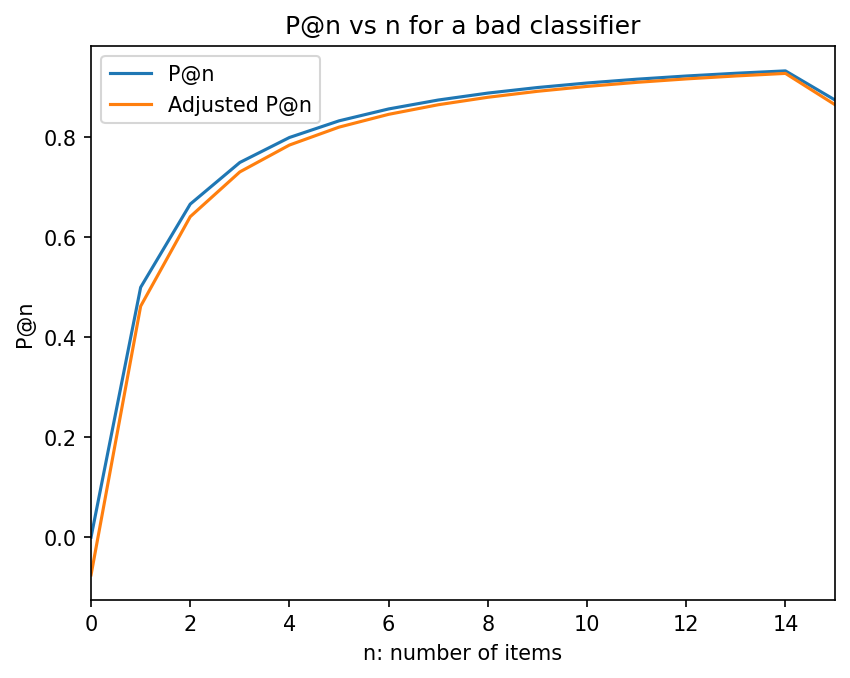

In [39]:
plt.figure(dpi=150)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.xlim(0, 15)
plt.legend()
plt.title('P@n vs n for a bad classifier');

As n is small, we see the effect of applying the “adjustment” (i.e. how well the classifier performs compared to random rankings).

## 5. Same data, different algorithm

Let's use some of the distance based algorithms. To make _good_ anomaly detection methods, we should apply 
- scaling of features
- maybe apply PCA for dimensional reduction.

We will take a naive approach and score the results using P@n and average precision. Then we will treat the data again with the proper preprocessing steps, and see how the results improve.

In [57]:
def do_nn_avg_outlier_scores(obs, n_neighbors=1):
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    scores = dists.mean(axis=1)
    return scores

In [41]:
features = df.drop('anomaly', axis=1)

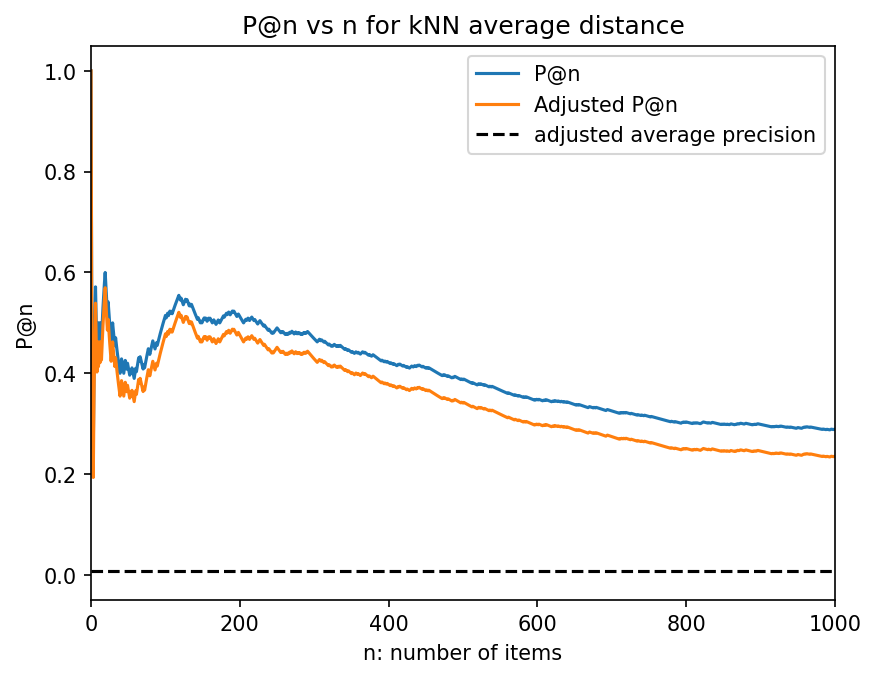

In [44]:
# we want lower numbers (i.e. larger negative distances) to be more likely to be outliers
y_scores = -do_nn_avg_outlier_scores(features, n_neighbors=20)

p_at_n = np.array(precision_at_n(df['anomaly'], y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = custom_average_precision(df['anomaly'], y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

plt.figure(dpi=150)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')

plt.axhline(adj_ave_precision, linestyle='--', color='k', 
            label='adjusted average precision')
plt.xlim(0, 1000)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n vs n for kNN average distance');

In [45]:
# scan for the best value of n (may take a while)
ap = [(custom_average_precision(df['anomaly'], do_nn_avg_outlier_scores(features, n_neighbors=n)), n)
      for n in range(2, 100)]

In [46]:
sorted(ap, reverse=True)[:5]

[(0.07260705349499433, 19),
 (0.07239241111685574, 74),
 (0.07213156802189982, 41),
 (0.0721297293486691, 7),
 (0.07197794905539764, 8)]

Looks like we get the best results for average precision with 99 neighbors!

**Using kNN again, but with scaling and dimensional reduction**

We need to do standard scaling when using distance based methods. The kNN method above demonstrates a _bad_ anomaly detector. We can see how our metrics can measure the difference between kNN done properly (with scaling and dimensional reduction) versus a naive method.

In [47]:
ssX = StandardScaler()
features_scaled = ssX.fit_transform(features.astype(float))

# How many features do we need?
pca = PCA()
pca.fit(features_scaled)
np.cumsum(pca.explained_variance_ratio_)

array([0.32991315, 0.52650241, 0.67768337, 0.81931787, 0.92839029,
       0.99980226, 0.9998828 , 0.99995741, 1.        ])

In [48]:
pca.explained_variance_ratio_

array([3.29913146e-01, 1.96589265e-01, 1.51180954e-01, 1.41634506e-01,
       1.09072419e-01, 7.14119727e-02, 8.05350452e-05, 7.46157458e-05,
       4.25860967e-05])

Looks like 6 components captures 99.9% of the variance, so we will reduce the dimensionality of our data accordingly.

In [49]:
pca = PCA(n_components=6)
pca_features = pca.fit_transform(features_scaled)

In [51]:
print(pca_features.shape)

(12345, 6)


Now let us try some different values of $k$ to see how many neighbors we should use. We will keep track of the average precision score, and the value of $k$ that gave us that score:

In [52]:
ap = [(custom_average_precision(df['anomaly'], do_nn_avg_outlier_scores(pca_features, n_neighbors=n)), n) 
      for n in range(100, 200)]

In [53]:
# Now look at the average precision score for different numbers of nearest neighbors
sorted(ap, reverse=True)[:5]

[(0.07249094007206065, 148),
 (0.07205510563544786, 152),
 (0.07180653599025588, 118),
 (0.07163209359565686, 130),
 (0.07155792553454655, 109)]

The score keeps increasing with the number of neighbors (i.e. we should keep increasing the number of neighbors beyond 200). Some experimentation shows that `n_neighbors` $\approx 600$ maximizes the average precision.

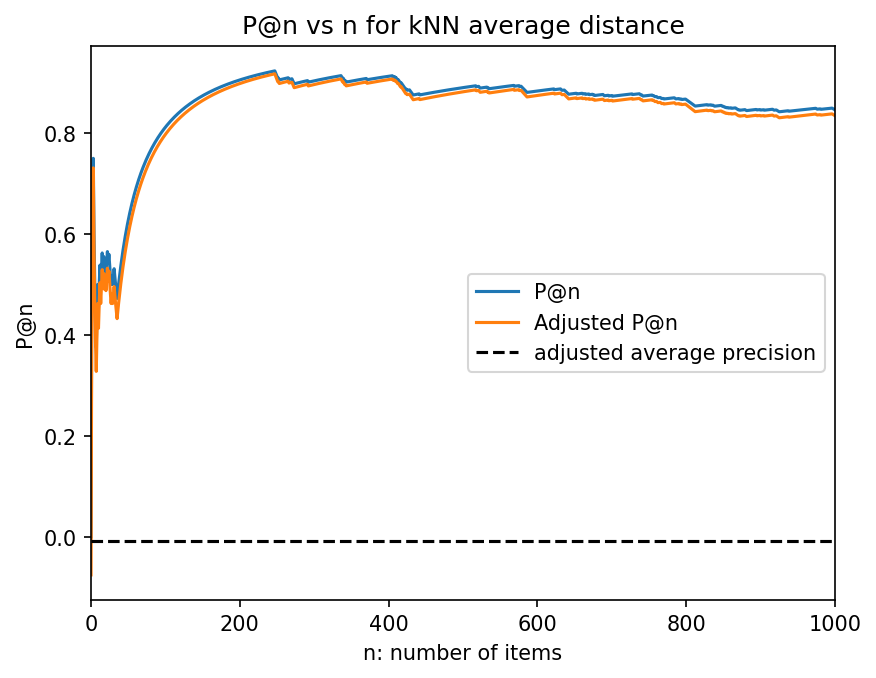

In [54]:
y_scores = -do_nn_avg_outlier_scores(pca_features, n_neighbors=600)

p_at_n = np.array(precision_at_n(df['anomaly'], y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = custom_average_precision(df['anomaly'], y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

plt.figure(dpi=150)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')

plt.axhline(adj_ave_precision, linestyle='--', color='k', 
            label='adjusted average precision')
plt.xlim(0, 1000)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n vs n for kNN average distance');

## 6. Using ROC

One of the standard metrics commonly used for both classification and anomaly detection is the Receiver Operator Characteristic Curve (ROC Curve). The curve shows the tradeoff between the false positive and false negative rates as the threshold for the score is varied.

The threshold can either be chosen as a cutoff score (typical for classification) or a cutoff rank (typical for anomaly detection problems).

The _area under the curve_ gives us a single number that tells us how well the classifier does at distinguishing between the two cases. The number can be interpreted as the probability that a randomly chosen anomaly has a higher score than a randomly chosen normal point.

\begin{equation*}
\text{AUC} = P(\text{score of random anomaly} > \text{score of random inlier})
\end{equation*}

In [58]:
roc_model = namedtuple('roc_model', 'name model_scores')

In [59]:
print(roc_model)

<class '__main__.roc_model'>


Getting the ROC AUC scores for the different models is straightforward:

In [60]:
roc_models = [
    roc_model('Isolation Forest', -iso_forest.decision_function(features)),
    roc_model('kNN no proprocessing', do_nn_avg_outlier_scores(features, n_neighbors=20)),
    roc_model('kNN processing', do_nn_avg_outlier_scores(pca_features, n_neighbors=600))
]

for model in roc_models:
    label = f"{model.name} ({roc_auc_score(df['anomaly'], model.model_scores):6.4f})"
    print(label)

Isolation Forest (0.9957)
kNN no proprocessing (0.8002)
kNN processing (0.9918)


We can also make the plot with all three ROC curves on it:

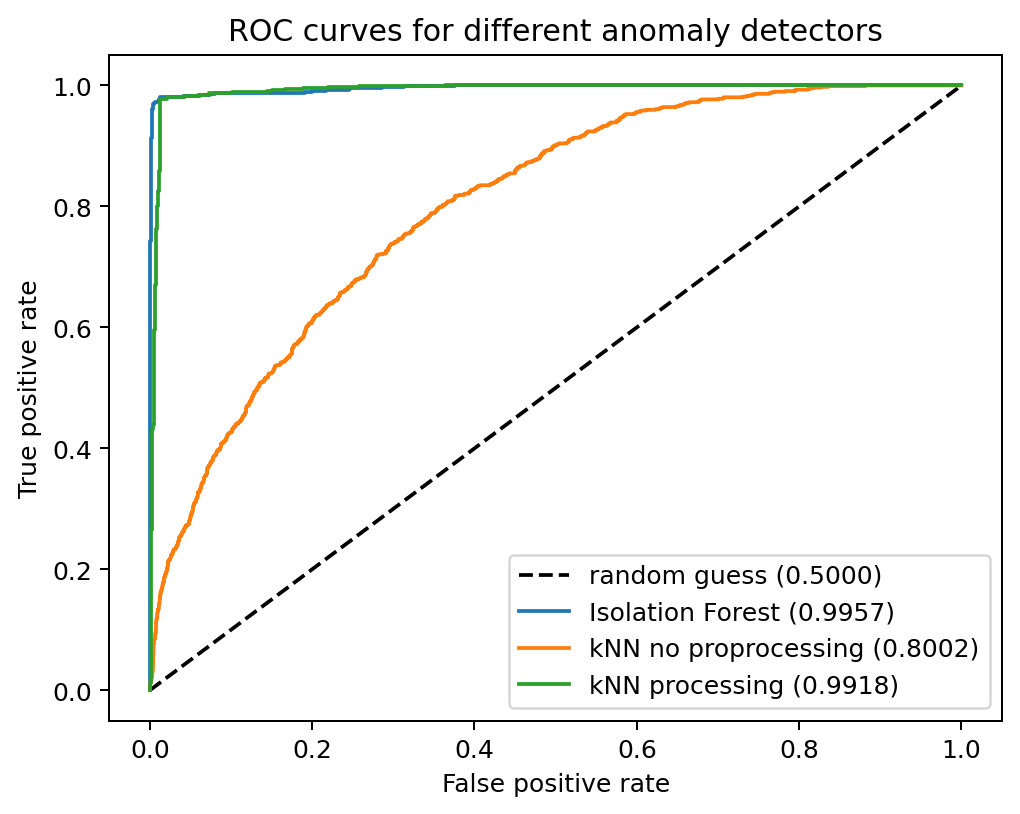

In [61]:
plt.figure(dpi=180)

plt.plot([0,1], [0,1], 'k--', label='random guess (0.5000)')

for model in roc_models:
    label = f"{model.name} ({roc_auc_score(df['anomaly'], model.model_scores):6.4f})"
    fpr, tpr, _ = roc_curve(df['anomaly'], model.model_scores)
    plt.plot(fpr, tpr, label=label)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves for different anomaly detectors")
plt.legend();

### Exercise #1

We don't cross-validate the results when fitting hyperparmaters for anomaly detection. Instead, we set a "reasonable range" of hyperparameters (usually determined by experience or a subject matter expert), then look at our metrics as the average over all parameter choice. 

Use $k=500$ to $k=600$ for the processed kNN model.
* What is the mean of the average precision (i.e. take the mean over the 100 models with k ranging from 500 to 600)
* What is the standard error of the average precision (i.e. find the standard error over the same 100 models).

Reminder: standard error is
$$\text{std err} = \frac{\sigma}{\sqrt{N}}$$
where $\sigma$ is the standard deviation and $N$ is the number of models you are averaging over

### Solution #1

In [62]:
ap = [(custom_average_precision(df['anomaly'], do_nn_avg_outlier_scores(pca_features, n_neighbors=n)), n) 
      for n in range(500, 600)]

# Now look at the average precision score for different numbers of nearest neighbors
sorted(ap, reverse=True)

[(0.07059164763281196, 569),
 (0.0705896506605833, 568),
 (0.07053263926798714, 541),
 (0.07048886454056912, 547),
 (0.07048040053090254, 561),
 (0.07046766058845938, 563),
 (0.07044730042095448, 573),
 (0.07042769683324938, 560),
 (0.07038414358285607, 542),
 (0.07038181272664976, 584),
 (0.07036176343142644, 558),
 (0.0703552596826392, 537),
 (0.07035001385367666, 544),
 (0.07034162860819164, 590),
 (0.07034148057115426, 511),
 (0.07033017269887189, 559),
 (0.07031827551934135, 532),
 (0.07031462485896076, 548),
 (0.07030937728419727, 520),
 (0.0703042738169519, 533),
 (0.07030055694284022, 564),
 (0.07028741837028665, 531),
 (0.07028477194239287, 586),
 (0.0702826938869216, 581),
 (0.07027538016566671, 530),
 (0.07027301515597797, 534),
 (0.0702594015060445, 580),
 (0.07025757940722398, 538),
 (0.07025474577959934, 567),
 (0.07025436811835324, 554),
 (0.07025227231405655, 597),
 (0.07024822084138946, 587),
 (0.07024355767281429, 572),
 (0.07023997755502008, 583),
 (0.070238910683350

In [64]:
score = []
for i in ap:
    score.append(i[0])
    scores = np.array(score)
    
mean = np.mean(scores)
sd = np.std(scores)
std_err = sd / np.sqrt(100)

    
print("Mean of the Average Precision Score: ", mean)
print("Standard error of the average precision: ", mean)

Mean of the Average Precision Score:  0.07015072244229001
Standard error of the average precision:  0.07015072244229001


### Exercise #2

Make a Local Outlier Factor anomaly detector on the (scaled) shuttle dataset, `pca_features`. What is the area under the ROC curve? Take the number of neighbors to range from 2000 to 3500 in steps of 100, and give the mean and standard error. 


### Solution #2

In [69]:
def do_LOF_scores(data, n_neighbors):
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, metric='manhattan')
    y_pred = clf.fit_predict(data)
    X_scores = clf.negative_outlier_factor_
    return X_scores
model_scores = -do_LOF_scores(pca_features, 2000)

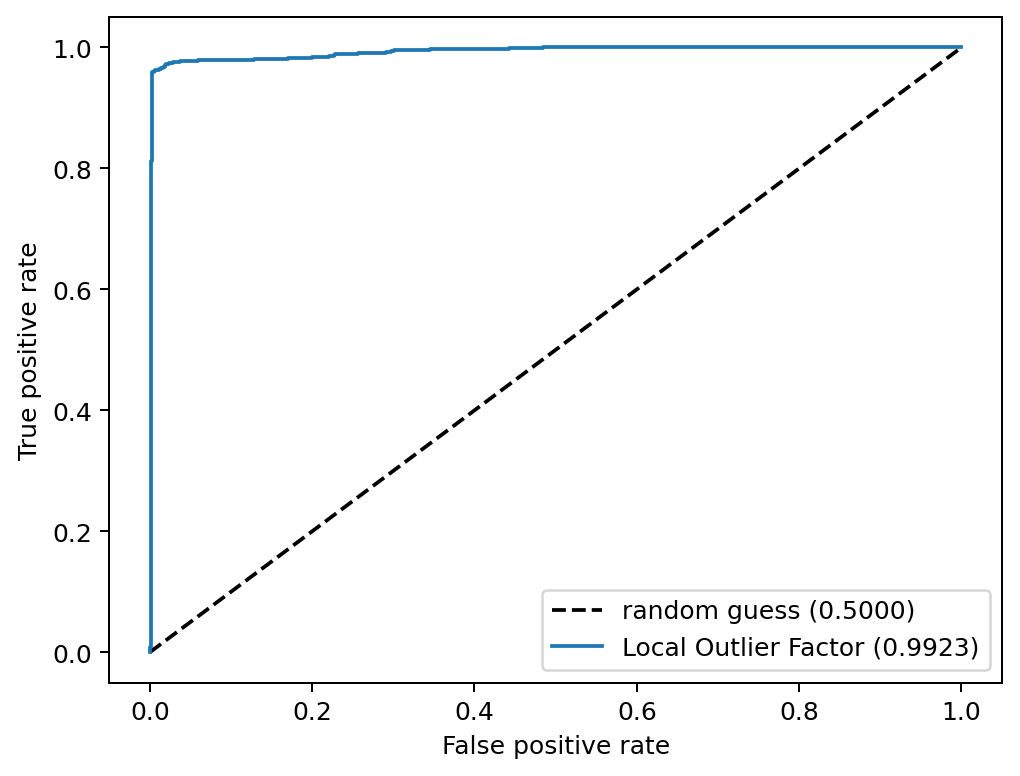

In [70]:
plt.figure(dpi=180)

plt.plot([0,1], [0,1], 'k--', label='random guess (0.5000)')

label = f"Local Outlier Factor ({roc_auc_score(df['anomaly'], model_scores):6.4f})"
fpr, tpr, _ = roc_curve(df['anomaly'], model_scores)
plt.plot(fpr, tpr, label=label)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend();

In [ ]:
ap = [(custom_average_precision(df['anomaly'], do_LOF_scores(pca_features, n_neighbors=n)), n) 
      for n in range(2000, 3500)]

# Now look at the average precision score for different numbers of nearest neighbors
sorted(ap, reverse=True)

In [ ]:
score = []
for i in ap:
    score.append(i[0])
    scores = np.array(score)
    
mean = np.mean(scores)
sd = np.std(scores)
std_err = sd / np.sqrt(100)

    
print("Mean of the Average Precision Score: ", mean)
print("Standard error of the average precision: ", mean)